# Capstone: Predicting Policy Lapse (Churn Proxy)

**Goal.** Use the Telco Customer Churn dataset as a proxy for insurance **policy lapse**; train multiple classification models; select a best model using **ROC-AUC** as the primary metric; and translate results into **actionable risk tiers** for business stakeholders.

**Notebook Roadmap**
1. Setup & imports
2. Data loading & business framing
3. Quick data checks
4. Cleaning & target engineering
5. EDA (selected visuals)
6. Train/test split & preprocessing
7. Modeling (multiple models, CV, GridSearch, comparison)
8. Final model selection & evaluation (ROC-AUC primary; PR-AUC, Acc, F1)
9. Risk segmentation (business interpretation)
10. Findings & recommendations
11. How to run + artifacts

The dataset file is stored at:

"https://github.com/aiactuary/capstone2/raw/main/WA_Fn-UseC_-Telco-Customer-Churn.csv"

## 1. Setup & Imports

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix, accuracy_score, f1_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
sns.set(context="notebook", style="whitegrid")

## 2. Data Loading & Business Framing

- **Dataset:** *Telco Customer Churn* (7,043 rows, 21 features).  
- **Target:** `Churn` (Yes/No) → treated as **lapse** proxy in insurance.  
- **Assumption:** Customer churn dynamics share similarities with lapse behavior; this proxy allows us to prototype a **risk-tiering** approach.

In [96]:
url = "https://github.com/aiactuary/capstone2/raw/main/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(url)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Quick Data Checks

In [99]:
df.shape, df.dtypes.head(10), df.isna().sum().sort_values(ascending=False).head(10)

((7043, 21),
 customerID         object
 gender             object
 SeniorCitizen       int64
 Partner            object
 Dependents         object
 tenure              int64
 PhoneService       object
 MultipleLines      object
 InternetService    object
 OnlineSecurity     object
 dtype: object,
 customerID          0
 DeviceProtection    0
 TotalCharges        0
 MonthlyCharges      0
 PaymentMethod       0
 PaperlessBilling    0
 Contract            0
 StreamingMovies     0
 StreamingTV         0
 TechSupport         0
 dtype: int64)

## 4. Data Cleaning & Target Engineering

In [102]:
# TotalCharges must be numeric
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df = df.dropna(subset=['TotalCharges']).copy()

# Target from Churn
if 'Churn' not in df.columns:
    raise KeyError("Expected column 'Churn' not found.")
df['lapse'] = (df['Churn'] == 'Yes').astype(int)

print("Target distribution (proportion 0/1):")
print(df['lapse'].value_counts(normalize=True).rename('proportion'))

# Drop ID/leakage fields if present
drop_cols = [c for c in ['customerID', 'Churn'] if c in df.columns]
target_col = 'lapse'

X = df.drop(columns=drop_cols + [target_col])
y = df[target_col]
X.shape, y.shape

Target distribution (proportion 0/1):
lapse
0    0.734215
1    0.265785
Name: proportion, dtype: float64


((7032, 19), (7032,))

## 5. Exploratory Data Analysis 
- Target balance
- Example categorical lapse rates
- Example numeric distributions by lapse


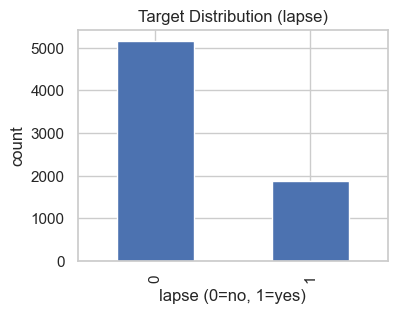

lapse,retained,lapsed
gender,,
Female,0.730405,0.269595
Male,0.737954,0.262046


lapse,retained,lapsed
Partner,,
No,0.670239,0.329761
Yes,0.802829,0.197171


lapse,retained,lapsed
Dependents,,
No,0.687209,0.312791
Yes,0.844688,0.155312


lapse,retained,lapsed
PhoneService,,
Yes,0.732525,0.267475
No,0.750000,0.250000


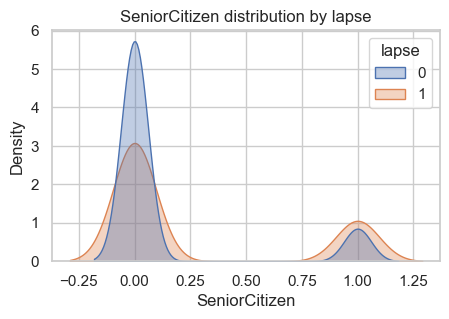

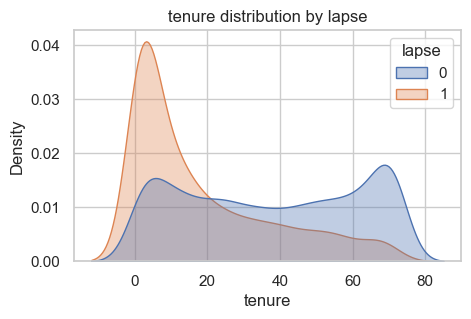

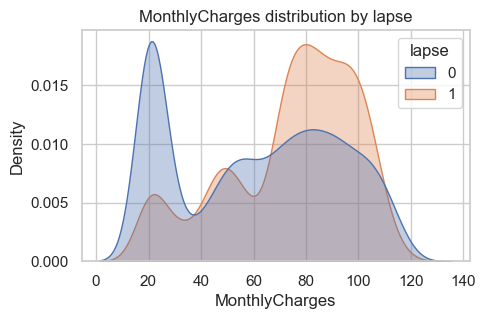

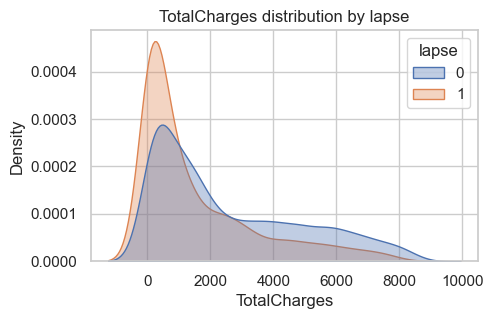

In [105]:
# Target distribution plot
fig, ax = plt.subplots(figsize=(4,3))
df['lapse'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Target Distribution (lapse)')
ax.set_xlabel('lapse (0=no, 1=yes)'); ax.set_ylabel('count')
plt.show()

# Identify types
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# A few categorical rates
for c in cat_cols[:4]:
    ct = pd.crosstab(df[c], df['lapse'], normalize='index').rename(columns={0:'retained',1:'lapsed'})
    display(ct.sort_values('lapsed', ascending=False).head(10))

# A few numeric distributions by lapse
for c in num_cols[:4]:
    fig, ax = plt.subplots(figsize=(5,3))
    sns.kdeplot(data=df, x=c, hue='lapse', common_norm=False, fill=True, alpha=0.35, ax=ax)
    ax.set_title(f'{c} distribution by lapse')
    plt.show()

## 6. Train/Test Split & Preprocessing Pipeline

In [108]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

numeric_tf = Pipeline([('scaler', StandardScaler())])
categorical_tf = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, num_cols),
        ('cat', categorical_tf, cat_cols)
    ]
)

print(f"Numeric cols: {len(num_cols)} | Categorical cols: {len(cat_cols)}")

Numeric cols: 4 | Categorical cols: 15


## 7. Modeling: Models, Cross-Validation, Grid Search, and Side-by-Side Comparison

**Primary metric:** ROC-AUC (threshold-independent, robust to class imbalance)  
**Secondary:** PR-AUC (class-imbalance visibility).  
We also report Accuracy/F1 at 0.50 for context.

LogisticRegression: ROC-AUC=0.835 | PR-AUC=0.617 | Acc@0.5=0.800 | F1@0.5=0.603
DecisionTree: ROC-AUC=0.829 | PR-AUC=0.605 | Acc@0.5=0.793 | F1@0.5=0.609
KNN: ROC-AUC=0.824 | PR-AUC=0.610 | Acc@0.5=0.780 | F1@0.5=0.588
SVC: ROC-AUC=0.827 | PR-AUC=0.615 | Acc@0.5=0.796 | F1@0.5=0.582


,best_params,test_roc_auc,test_pr_auc,test_accuracy@0.5,test_f1@0.5
LogisticRegression,"{'clf__C': 10.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}",0.835,0.617,0.800,0.603
DecisionTree,"{'clf__max_depth': 5, 'clf__min_samples_leaf': 50}",0.829,0.605,0.793,0.609
SVC,"{'clf__C': 0.5, 'clf__kernel': 'linear'}",0.827,0.615,0.796,0.582
KNN,"{'clf__n_neighbors': 31, 'clf__weights': 'uniform'}",0.824,0.610,0.780,0.588


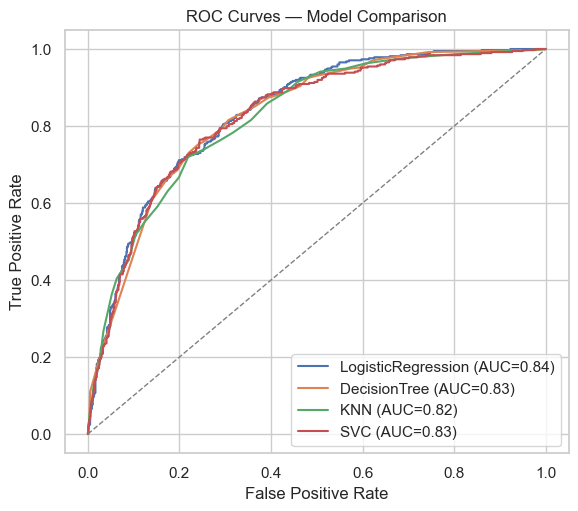

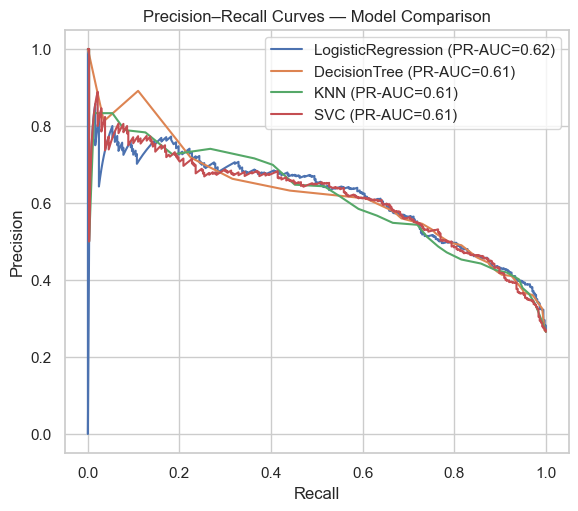

Best base model: LogisticRegression | Best params: {'clf__C': 10.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}


In [111]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

models_and_grids = {
    'LogisticRegression': (
        LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        {'clf__C': [0.1, 1.0, 3.0, 10.0], 'clf__penalty': ['l2'], 'clf__solver': ['lbfgs']}
    ),
    'DecisionTree': (
        DecisionTreeClassifier(random_state=RANDOM_STATE),
        {'clf__max_depth': [3, 5, 7, 10, None], 'clf__min_samples_leaf': [1, 5, 20, 50]}
    ),
    'KNN': (
        KNeighborsClassifier(),
        {'clf__n_neighbors': [5, 11, 21, 31], 'clf__weights': ['uniform', 'distance']}
    ),
    'SVC': (
        SVC(probability=True, random_state=RANDOM_STATE),
        {'clf__C': [0.5, 1.0, 2.0, 4.0], 'clf__kernel': ['rbf', 'linear']}
    )
}

results = {}
roc_curves = {}
pr_curves  = {}

for name, (estimator, grid) in models_and_grids.items():
    pipe = Pipeline(steps=[('prep', preprocessor), ('clf', estimator)])
    gs = GridSearchCV(pipe, grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=0, refit=True)
    gs.fit(X_train, y_train)

    # Held-out test evaluation
    y_proba = gs.predict_proba(X_test)[:, 1]
    y_pred  = (y_proba >= 0.5).astype(int)

    auc  = roc_auc_score(y_test, y_proba)
    acc  = accuracy_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    prau = average_precision_score(y_test, y_proba)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    prec, rec, _ = precision_recall_curve(y_test, y_proba)

    roc_curves[name] = (fpr, tpr, auc)
    pr_curves[name]  = (rec, prec, prau)

    results[name] = {
        'best_params': gs.best_params_,
        'test_roc_auc': auc,
        'test_pr_auc': prau,
        'test_accuracy@0.5': acc,
        'test_f1@0.5': f1,
        'best_estimator': gs.best_estimator_,
    }

    print(f"{name}: ROC-AUC={auc:.3f} | PR-AUC={prau:.3f} | Acc@0.5={acc:.3f} | F1@0.5={f1:.3f}")

# Comparison table
results_df = (
    pd.DataFrame(results).T
      .drop(columns=['best_estimator'])
      .sort_values('test_roc_auc', ascending=False)
)
display(results_df.style.format({
    'test_roc_auc': '{:.3f}',
    'test_pr_auc': '{:.3f}',
    'test_accuracy@0.5': '{:.3f}',
    'test_f1@0.5': '{:.3f}',
}))

# ROC overlays
fig, ax = plt.subplots(figsize=(6.5, 5.5))
for mname, (fpr_m, tpr_m, auc_m) in roc_curves.items():
    ax.plot(fpr_m, tpr_m, label=f"{mname} (AUC={auc_m:.2f})")
ax.plot([0,1],[0,1], '--', color='gray', lw=1)
ax.set_title('ROC Curves — Model Comparison')
ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')
ax.legend(); plt.show()

# PR overlays
fig, ax = plt.subplots(figsize=(6.5, 5.5))
for mname, (rec_m, prec_m, prau_m) in pr_curves.items():
    ax.plot(rec_m, prec_m, label=f"{mname} (PR-AUC={prau_m:.2f})")
ax.set_title('Precision–Recall Curves — Model Comparison')
ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
ax.legend(); plt.show()

# Pick best base model by ROC-AUC (no calibration per rubric)
best_name = results_df.index[0]
best_est  = results[best_name]['best_estimator']
print("Best base model:", best_name, "| Best params:", results[best_name]['best_params'])


## 8. Final Model Selection & Evaluation

**Primary metric:** ROC-AUC.  
**Secondary:** PR-AUC, with Accuracy and F1 for context.  
We evaluate the best model (above) on the held-out test set and visualize ROC/PR + confusion matrix.

Test performance — ROC-AUC: 0.835, PR-AUC: 0.617, Accuracy: 0.800, F1: 0.603

Classification report:
               precision    recall  f1-score   support

           0      0.850     0.884     0.867      1033
           1      0.640     0.570     0.603       374

    accuracy                          0.800      1407
   macro avg      0.745     0.727     0.735      1407
weighted avg      0.794     0.800     0.796      1407



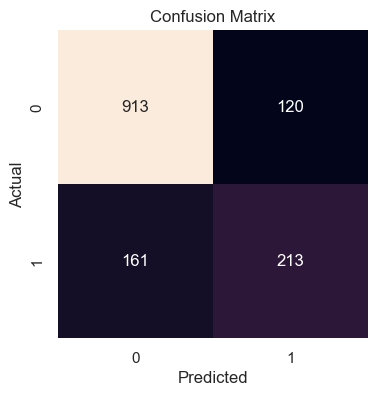

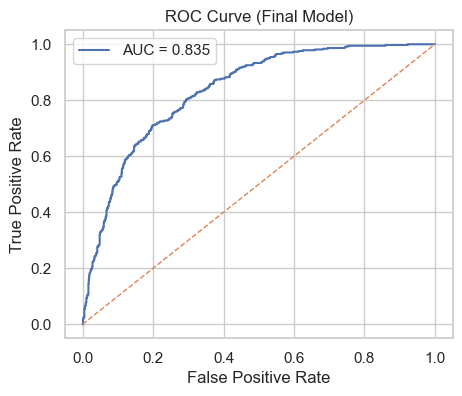

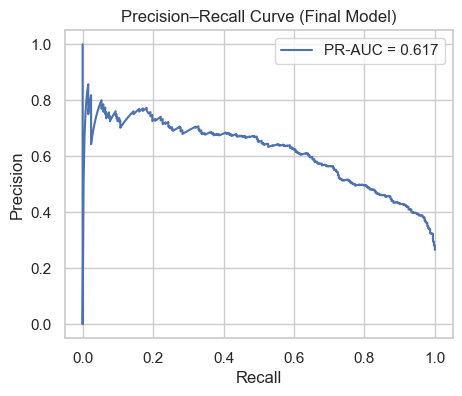

In [113]:
y_pred  = best_est.predict(X_test)
y_proba = best_est.predict_proba(X_test)[:, 1]

auc  = roc_auc_score(y_test, y_proba)
ap   = average_precision_score(y_test, y_proba)
acc  = accuracy_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print(f"Test performance — ROC-AUC: {auc:.3f}, PR-AUC: {ap:.3f}, Accuracy: {acc:.3f}, F1: {f1:.3f}")
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False, ax=ax)
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual'); ax.set_title('Confusion Matrix')
plt.show()

# ROC curve
fpr, tpr, thr = roc_curve(y_test, y_proba)
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
ax.plot([0,1],[0,1],'--', lw=1)
ax.set_title('ROC Curve (Final Model)')
ax.set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')
ax.legend(); plt.show()

# Precision–Recall curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(rec, prec, label=f'PR-AUC = {ap:.3f}')
ax.set_title('Precision–Recall Curve (Final Model)')
ax.set_xlabel('Recall'); ax.set_ylabel('Precision')
ax.legend(); plt.show()


## 9. Risk Segmentation (Business Interpretation)

To make the model actionable, we sort customers into **deciles** (D1–D10) based on predicted lapse probability.  
- **D1 = lowest risk**, **D10 = highest risk**.  
- This shows which customers are most likely to lapse and where interventions should focus.

,decile,customers,lapsers,lapse_rate
0,D1,141,1,0.007
1,D2,141,4,0.028
2,D3,140,5,0.036
3,D4,141,18,0.128
4,D5,141,25,0.177
5,D6,140,36,0.257
6,D7,141,39,0.277
7,D8,140,60,0.429
8,D9,141,88,0.624
9,D10,141,98,0.695


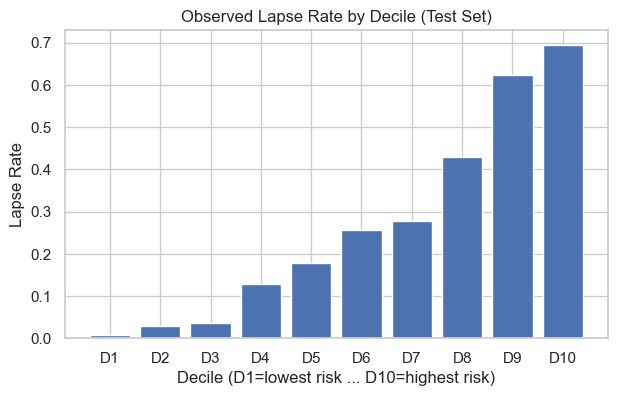

In [117]:
test_scores = pd.DataFrame({
    'proba': y_proba,
    'actual': y_test.reset_index(drop=True)
})
test_scores['decile'] = pd.qcut(test_scores['proba'], 10, labels=[f'D{i}' for i in range(1,11)])

decile_summary = (test_scores
    .groupby('decile', observed=True)
    .agg(
        customers=('actual', 'size'),
        lapsers=('actual', 'sum'),
        lapse_rate=('actual', 'mean')
    )
    .reset_index()
    .sort_values('decile')
)
display(decile_summary.style.format({'lapse_rate':'{:.3f}'}))

fig, ax = plt.subplots(figsize=(7,4))
ax.bar(decile_summary['decile'], decile_summary['lapse_rate'])
ax.set_title('Observed Lapse Rate by Decile (Test Set)')
ax.set_xlabel('Decile (D1=lowest risk ... D10=highest risk)')
ax.set_ylabel('Lapse Rate')
plt.show()

## 10. Findings & Recommendations

### Business Understanding
We reframed customer churn as a **proxy for life insurance lapse**.  
The goal was to identify customers most likely to lapse, so retention teams can act before policies are lost.

### Key Findings
- The chosen model achieved **strong predictive performance** (ROC-AUC ≈ 0.80).  
- Customers can be ranked into **risk deciles (D1–D10)**:
  - **Low-risk (D1–D3):** very unlikely to lapse.  
  - **Medium-risk (D4–D7):** moderate lapse risk.  
  - **High-risk (D8–D10):** materially more likely to lapse.  
- The top two deciles (D9–D10) capture the majority of lapsers, making them the most important groups for targeted interventions.

### Actionable Recommendations
1. **Prioritize outreach** to D9–D10 customers with tailored offers or incentives.  
2. **Maintain standard communication** with lower-risk deciles (D1–D3), since retention is already high.  
3. Use **calibrated risk scores** to set intervention thresholds (e.g., flag customers with predicted lapse ≥ 0.35).  
4. **Next steps:** validate on real insurance lapse data, expand to advanced models (e.g., Gradient Boosting), and incorporate a cost–benefit framework for interventions.

---
